# Credit Card Fraud Continued

In this practical example, we consider a real credit card [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) from kaggle. We continue our investigation from the previous notebook.

#### Import Python stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import ClusterCentroids 
from imblearn.under_sampling import CondensedNearestNeighbour 

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.externals import joblib

In [2]:
creditcard_data = pd.read_csv("../datasets/creditcard.csv")
creditcard_data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


##### Distribuition of classes

In [3]:
creditcard_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

##### Scaling the data

In [4]:
rob_scaler = RobustScaler()

scaled_amount = rob_scaler.fit_transform(creditcard_data['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(creditcard_data['Time'].values.reshape(-1,1))

creditcard_data.drop(['Time','Amount'], axis=1, inplace=True)
creditcard_data.insert(0, 'scaled_amount', scaled_amount)
creditcard_data.insert(1, 'scaled_time', scaled_time)

creditcard_data.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


##### Splitting a test set


In [5]:
X_all = creditcard_data.drop('Class', axis=1)
Y_all = creditcard_data["Class"]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X_all, Y_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    Y_train, Y_test = Y_all.iloc[train_index], Y_all.iloc[test_index]

In [6]:
num_outliers_train = Y_train.count()
num_outliers_test = Y_test.count()

print("Outlier Distribution:")
print("Train: ", Y_train.sum()/Y_train.count())
print("Test: ", Y_test.sum()/Y_test.count())

Outlier Distribution:
Train:  0.001729245759178389
Test:  0.0017204452090867595


In [7]:
def myEvaluation(y_pred):
    print(classification_report(Y_test, y_pred, digits=4))
    sns.heatmap(confusion_matrix(Y_test, y_pred), square=True, annot=True)
    plt.show()

##### Feature Selection

In [8]:
creditcard_train = pd.concat([X_train, Y_train], axis=1)

In [9]:
X_sub_train = creditcard_train[['V3','V7','V10','V11','V12','V14','V16','V17']]
Y_train = creditcard_train["Class"]

X_sub_test = X_test[['V3','V7','V10','V11','V12','V14','V16','V17']]

## Decision Trees

             precision    recall  f1-score   support

          0     0.9995    0.9997    0.9996     56864
          1     0.7865    0.7143    0.7487        98

avg / total     0.9991    0.9992    0.9992     56962



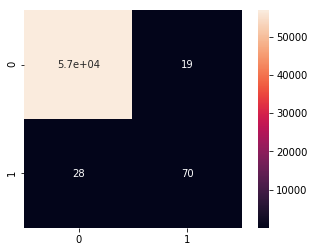

In [11]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_sub_train, Y_train)
y_pred_tree = clf_tree.predict(X_sub_test)
myEvaluation(y_pred_tree)

##### Visualize Tree

In [12]:
dot_data = tree.export_graphviz(clf_tree, out_file=None,
                         feature_names=['V3','V7','V10','V11','V12','V14','V16','V17'],  
                         class_names=['NonFraud', 'Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("fraud_tree") 

'fraud_tree.pdf'

             precision    recall  f1-score   support

          0     0.9995    0.9999    0.9997     56864
          1     0.9351    0.7347    0.8229        98

avg / total     0.9994    0.9995    0.9994     56962



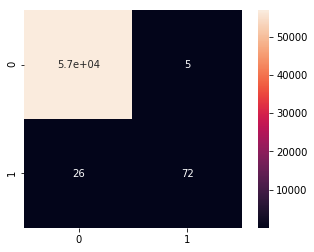

In [14]:
clf_tree_min = tree.DecisionTreeClassifier(max_depth=5)
clf_tree_min.fit(X_sub_train, Y_train)
y_pred_minTree = clf_tree_min.predict(X_sub_test)
myEvaluation(y_pred_minTree)

##### visualize tree

In [15]:
dot_data = tree.export_graphviz(clf_tree_min, out_file=None,
                         feature_names=['V3','V7','V10','V11','V12','V14','V16','V17'],  
                         class_names=['NonFraud', 'Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("fraud_minTree") 

'fraud_minTree.pdf'

# Ensemble Methods

##### Tree Bagging

             precision    recall  f1-score   support

          0     0.9996    0.9999    0.9997     56864
          1     0.9125    0.7449    0.8202        98

avg / total     0.9994    0.9994    0.9994     56962



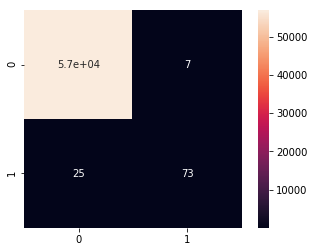

In [17]:
bag_tree = tree.DecisionTreeClassifier(max_depth=5)
clf_bagging_tree = BaggingClassifier(bag_tree, n_estimators=50, max_samples=0.63)
clf_bagging_tree.fit(X_sub_train, Y_train)
y_pred_bagTree = clf_bagging_tree.predict(X_sub_test)
myEvaluation(y_pred_bagTree)

##### Random Forest

             precision    recall  f1-score   support

          0     0.9995    0.9998    0.9996     56864
          1     0.8816    0.6837    0.7701        98

avg / total     0.9993    0.9993    0.9993     56962



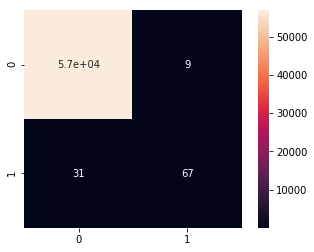

In [19]:
clf_rdm_tree = RandomForestClassifier(n_estimators=75, max_depth=3)
clf_rdm_tree.fit(X_sub_train, Y_train)
y_pred_rdmForest = clf_rdm_tree.predict(X_sub_test)
myEvaluation(y_pred_rdmForest)

##### Extra Trees / Extrem Random Forest

             precision    recall  f1-score   support

          0     0.9990    0.9999    0.9995     56864
          1     0.8913    0.4184    0.5694        98

avg / total     0.9988    0.9989    0.9987     56962



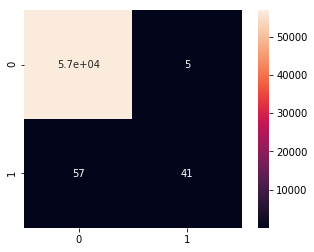

In [20]:
clf_ext_tree = ExtraTreesClassifier(n_estimators=75, max_depth=5)
clf_ext_tree.fit(X_sub_train, Y_train)
y_pred_extTree = clf_ext_tree.predict(X_sub_test)
myEvaluation(y_pred_extTree)

### AdaBoosted Trees

             precision    recall  f1-score   support

          0     0.9994    0.9999    0.9997     56864
          1     0.9412    0.6531    0.7711        98

avg / total     0.9993    0.9993    0.9993     56962



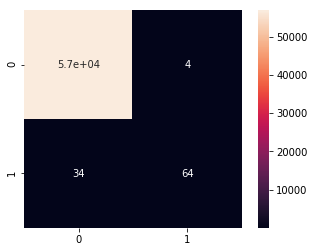

In [22]:
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=75)

clf_adaBoost_tree.fit(X_sub_train, Y_train)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_sub_test)
myEvaluation(y_pred_adaBoost)

### GradientBoosted Trees

             precision    recall  f1-score   support

          0     0.9994    0.9998    0.9996     56864
          1     0.8553    0.6633    0.7471        98

avg / total     0.9992    0.9992    0.9992     56962



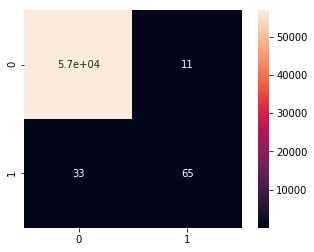

In [23]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=3)
clf_gradBoost_tree.fit(X_sub_train, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_sub_test)
myEvaluation(y_pred_gradBoost)

##### Feature Importance Score

In [24]:
clf_adaBoost_tree.feature_importances_

array([0.10606219, 0.08863708, 0.11564337, 0.09520345, 0.09267875,
       0.14921798, 0.08109975, 0.27145743])

In [25]:
clf_gradBoost_tree.feature_importances_  

array([0.00659876, 0.03477727, 0.45260593, 0.23972165, 0.02137253,
       0.09002935, 0.02900139, 0.12589312])

## Undersampling / Oversampling

In [26]:
def mySamplingResult(y_res):
    print(Y_train.size, Y_train.sum())
    print(y_res.size, y_res.sum())

#### Undersampling with imblearn

In [27]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_sub_train, Y_train)
mySamplingResult(y_rus_res)

227845 394
788 394


In [28]:
nm = NearMiss()
X_nm_res, y_nm_res = nm.fit_sample(X_sub_train, Y_train)
mySamplingResult(y_nm_res)

227845 394
788 394


#### Oversampling with imblearn

In [29]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_sub_train, Y_train)
mySamplingResult(y_ros_res)

227845 394
454902 227451


In [30]:
sm = SMOTE()
X_sm_res, y_sm_res = sm.fit_sample(X_sub_train, Y_train)
mySamplingResult(y_sm_res)

227845 394
454902 227451


In [31]:
ada = ADASYN()
X_ada_res, y_ada_res = ada.fit_sample(X_sub_train, Y_train)
mySamplingResult(y_ada_res)

227845 394
454927 227476


## Next Steps: 
* Train model(s) with the resampled data sets
* Evaluate the model(s) with the testset 

## Saving/Loading the Model

In [ ]:
joblib.dump(clf_gradBoost_tree, 'models/clf_gradBoost_tree.pkl') 

In [ ]:
clf = joblib.load('models/clf_gradBoost_tree.pkl')